**BUSINESS PROBLEM**
  Mercari asked us to build a machine learning model which
tries to best fit the given features of the products and predicts the
prices of those products. Since we are predicting the prices of
products,it poses a regression problem. If we predict the price to
be much lower than the actual market price the it would be a loss
for person who sells the product,if we predict the price to be
much higher than the actual market price then it would be a loss
for person who buys that product,so the model we are predicting
should be very precise i.e it should predict the prices within in the
within the close vicinity of the actual price.
strictly speaking there is no latency constraint because
people may wait for time to get the correct prices of the products
so that no one will get loss i.e both buyer and seller.


**ML PROBLEM FORMULATION**
   here we have to predict the price of a product given with features,which is a numerical value,so it poses us a regression problem

**PERFORMANC METRIC**
  performance metric here we are using is root mean squared logarithmic error,instead of mse because the prices in training dataset follows the lo_nrmal distribution. 
     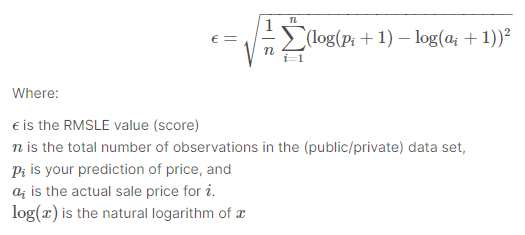

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import os
from concurrent.futures import ThreadPoolExecutor,as_completed
import pickle
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import mean_squared_error
import math

In [ ]:
train=pd.read_csv('train.tsv',sep='\t')

In [ ]:
train.head(5)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [ ]:
train.shape

(1482535, 8)

In [ ]:
test=pd.read_csv('test_stg2.tsv',sep='\t')

In [ ]:
test.shape

(3460725, 7)

In [ ]:
train.isna().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

**filling missing values in train**

In [ ]:
%%time
train.category_name.fillna(value='others/others/others',inplace=True)
train.item_description.fillna(value='description not given',inplace=True)
list1=list(train['brand_name'].unique())
list1 = list(filter(lambda x:str(x) !='nan',list1))
data=train[train['brand_name'].isnull()]
train.dropna(inplace=True)
data['comb']=data['name']+' '+data['item_description']
list2=data['comb'].values
brand_list=[]
for i in list2:
    c=0
    for j in list1:
        if j in i:
            brand_list.append(j)
            c=1
            break
    if c==0:
        brand_list.append(np.nan)        
data['brand_name']=brand_list
data.brand_name.fillna(value='unknown',inplace=True)
train=pd.concat([train,data],ignore_index=True)
train=train.sort_values(by='train_id')
train.isna().sum()

CPU times: user 5min 40s, sys: 60.2 ms, total: 5min 40s
Wall time: 5min 40s


train_id                  0
name                      0
item_condition_id         0
category_name             0
brand_name                0
price                     0
shipping                  0
item_description          0
comb                 849853
dtype: int64

In [ ]:
train.drop('comb',axis=1,inplace=True)

In [ ]:
train.shape

(1482535, 8)

**filling missing values in test**

In [ ]:
test.isna().sum()

test_id                    0
name                       0
item_condition_id          0
category_name          14833
brand_name           1476490
shipping                   0
item_description           6
dtype: int64

In [ ]:
%%time
test.category_name.fillna(value='others/others/others',inplace=True)
test.item_description.fillna(value='description not given',inplace=True)
list1=list(test['brand_name'].unique())
list1 = list(filter(lambda x:str(x) !='nan',list1))
data=test[test['brand_name'].isnull()]
test.dropna(inplace=True)
data['comb']=data['name']+' '+data['item_description']
list2=data['comb'].values
brand_list=[]
for i in list2:
    c=0
    for j in list1:
        if j in i:
            brand_list.append(j)
            c=1
            break
    if c==0:
        brand_list.append(np.nan)
data['brand_name']=brand_list
print(data.isna().sum())
data.brand_name.fillna(value='unknown',inplace=True)
test=pd.concat([test,data],ignore_index=True)
test=test.sort_values(by='test_id')
test.drop('comb',axis=1,inplace=True)
test.isna().sum()

test_id                   0
name                      0
item_condition_id         0
category_name             0
brand_name           453320
shipping                  0
item_description          0
comb                      0
dtype: int64
CPU times: user 14min 53s, sys: 428 ms, total: 14min 53s
Wall time: 14min 53s


test_id              0
name                 0
item_condition_id    0
category_name        0
brand_name           0
shipping             0
item_description     0
dtype: int64

In [ ]:
test.shape

(3460725, 7)

**univariate analysis**

array([[<AxesSubplot:title={'center':'price'}>]], dtype=object)

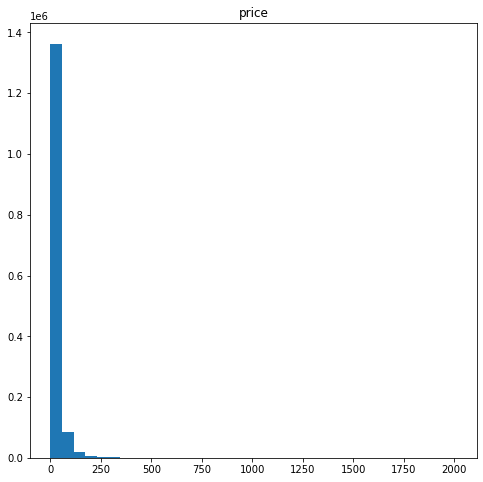

In [ ]:
train.hist(column='price',bins=35,grid=False,figsize=[8,8])

In [ ]:
#from the histogram plot of price it is clear that most of prices falles below 250
train['price'].quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])

0.1       7.0
0.2      10.0
0.3      12.0
0.4      14.0
0.5      17.0
0.6      20.0
0.7      26.0
0.8      34.0
0.9      51.0
1.0    2009.0
Name: price, dtype: float64

In [ ]:
train['price'].quantile([0.90,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99])
#99 percent of data points have price less than 200

0.90     51.0
0.91     55.0
0.92     58.0
0.93     62.0
0.94     67.0
0.95     75.0
0.96     85.0
0.97     99.0
0.98    122.0
0.99    170.0
Name: price, dtype: float64

In [ ]:
train=train[train['price']<250]

In [ ]:
perce_90th=train.price.quantile(0.9)

In [ ]:
print(train.shape)

(1482535, 8)


In [ ]:
train.name.nunique()

1225273

In [ ]:
train.brand_name.nunique()

4810

In [ ]:
def split(text):
  return text.split('/')
train['cat_1'],train['cat_2'],train['cat_3']=zip(*train['category_name'].apply(lambda i:split(i)))  
test['cat_1'],test['cat_2'],test['cat_3']=zip(*test['category_name'].apply(lambda i:split(i)))

In [ ]:
train['log']=np.log(train['price']+1)

array([[<AxesSubplot:title={'center':'log'}>]], dtype=object)

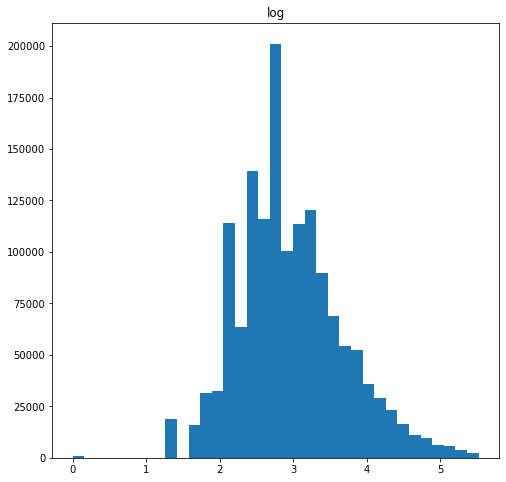

In [ ]:
train.hist(column='log',bins=35,grid=False,figsize=[8,8])

**observations**
1. here we have observed that histogram graph of log of prices follows normal distributions.which means our price distribution follows log-normal distribution..that is why we are using root mean squared logarithmic error instead of root mean squared error 

Text(0.5, 1.0, 'shipping')

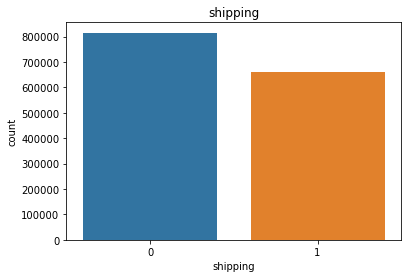

In [ ]:
# here we are plotting the count plot for shipping column. the count of 0's and 1's in shipping column are almost equal 
plt.figure()
sns.countplot(train['shipping'])
plt.title('shipping')

**observations**
1.from the counterplot of shipping it is observd that products with shipping price paid by the paid by the buyer are more when compared to the products with shipping price paid by the seller

Text(0.5, 1.0, 'item_condition')

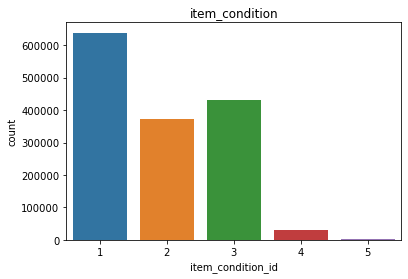

In [ ]:
# plotting the count plot for item_coondition_id, as we see most of the items conditions falls in 1,2,3, category 
plt.figure()
sns.countplot(train['item_condition_id'])
plt.title('item_condition')

**observations**
1. from the counter plot on item_condition it is clear that most of the product are in good condition with value 1.followed by the 3 and 2.very few products are in bad condition with item_condtion_id as 5 followed by 4.

In [ ]:
print(list(train['brand_name'].value_counts()[:20].index))

['unknown', 'M', 'Nike', 'PINK', "Victoria's Secret", 'LuLaRoe', 'All', 'Apple', 'Nintendo', 'Rae Dunn', 'FOREVER 21', 'Michael Kors', 'Lululemon', 'Disney', 'American Eagle', 'X', 'Sephora', 'Coach', 'Adidas', 'Funko']


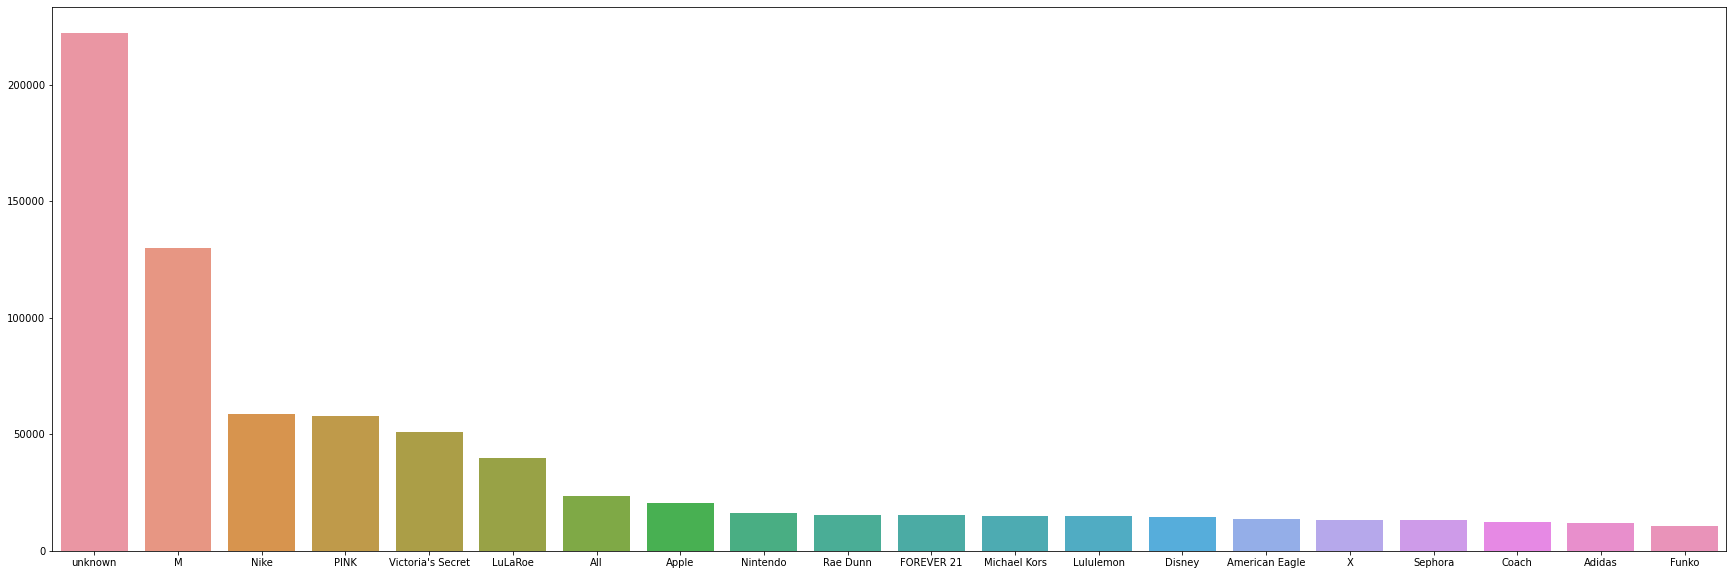

In [ ]:
#printing the the top 20 brands with respect to their counts
# most of the items falls within the brand unkown,which means for most of the products brand name is not given
plt.figure(figsize = (30,10))
sns.barplot(list(train['brand_name'].value_counts()[:20].index),list(train['brand_name'].value_counts()[:20]))
plt.show()

**observatios**
1. most of the products are not given brand_name.and after that most of the products are comming for the brand M,Nike,pink.which tell us that people are interested in buying things are females.

In [ ]:
print(list(train['cat_1'].value_counts().index))

['Women', 'Beauty', 'Kids', 'Electronics', 'Men', 'Home', 'Vintage & Collectibles', 'Other', 'Handmade', 'Sports & Outdoors', 'others']


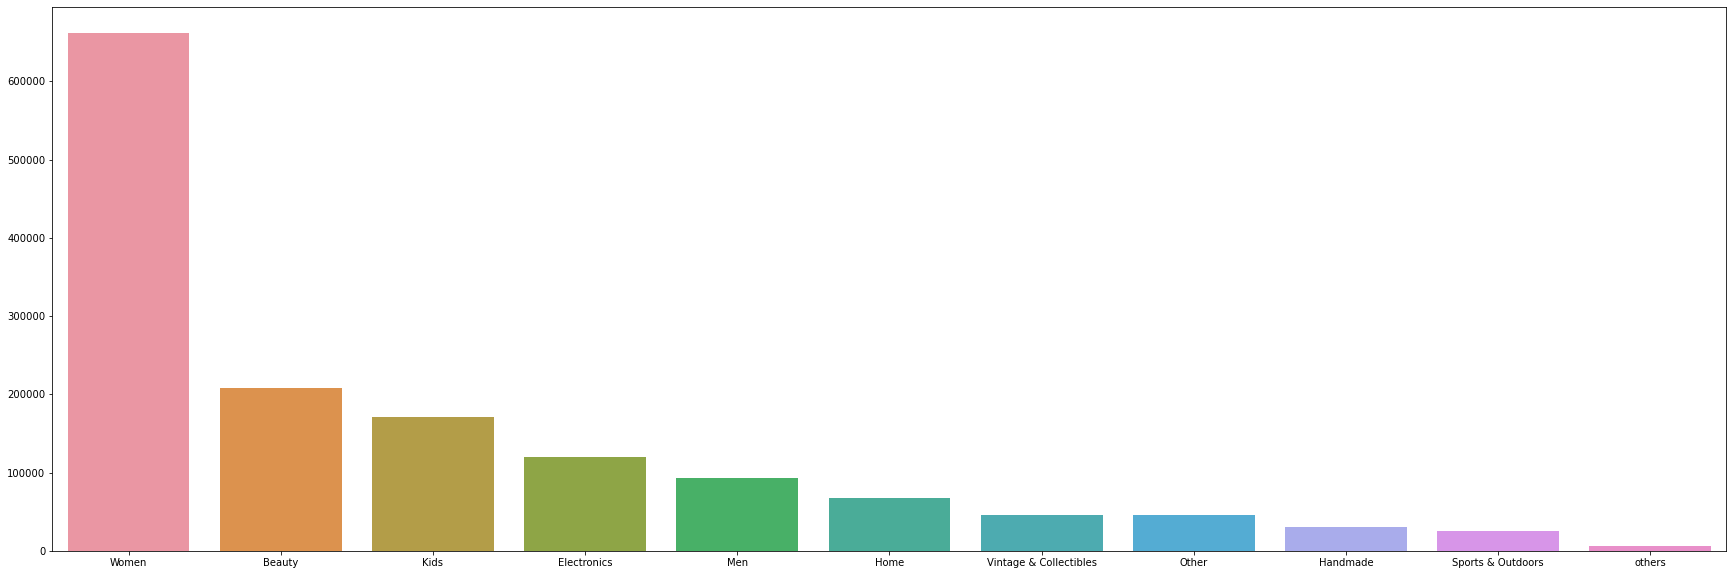

In [ ]:
#printing the the top 20 cat_1 with respect to their counts
# most of cat_1 fall with in the category women and beauty.
plt.figure(figsize = (30,10))
sns.barplot(list(train['cat_1'].value_counts().index),list(train['cat_1'].value_counts()))
plt.show()

**observations**
1.from the bar plot of cat_1 feature we observed that top 2 categories are related with females and next category related to kids which tell us that most people who are shopping in mercari are females. 

In [ ]:
print(list(train['cat_2'].value_counts()[:20].index))

['Athletic Apparel', 'Makeup', 'Tops & Blouses', 'Shoes', 'Jewelry', 'Toys', 'Cell Phones & Accessories', 'Dresses', "Women's Handbags", "Women's Accessories", 'Jeans', 'Sweaters', 'Video Games & Consoles', 'Underwear', 'Skin Care', 'Home Décor', 'Fragrance', 'Kitchen & Dining', 'Tops', 'Other']


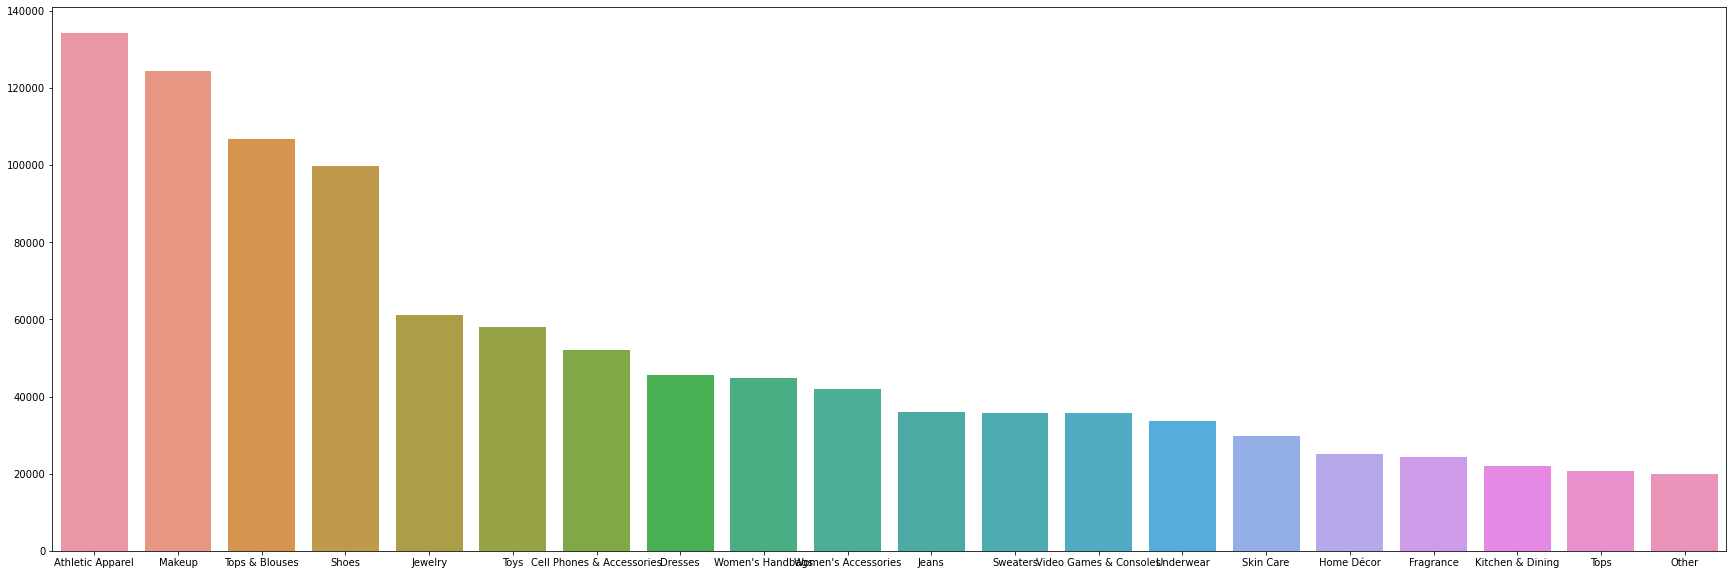

In [ ]:
#printing the the top 20 cat_2 with respect to their counts
# most of cat_2 fall with in the category athletic approval,makeup,tps & blouses and shoes
plt.figure(figsize = (30,10))
sns.barplot(list(train['cat_2'].value_counts()[:20].index),list(train['cat_2'].value_counts()[:20]))
plt.show()

**observations**
1.top category in cat_2 is athletic apparelwhich tell us that lot many sports people are using mercari and there might be lot many other products related to womens as second and third categories are makeup and tops and blouses.  

In [ ]:
print(list(train['cat_3'].value_counts()[:20].index))

['Pants, Tights, Leggings', 'Face', 'Other', 'T-Shirts', 'Shoes', 'Lips', 'Games', 'Athletic', 'Eyes', 'Cases, Covers & Skins', 'Shorts', 'Bras', 'Tank, Cami', 'Blouse', 'Boots', 'Above Knee, Mini', 'Necklaces', 'Makeup Palettes', 'Women', 'Shirts & Tops']


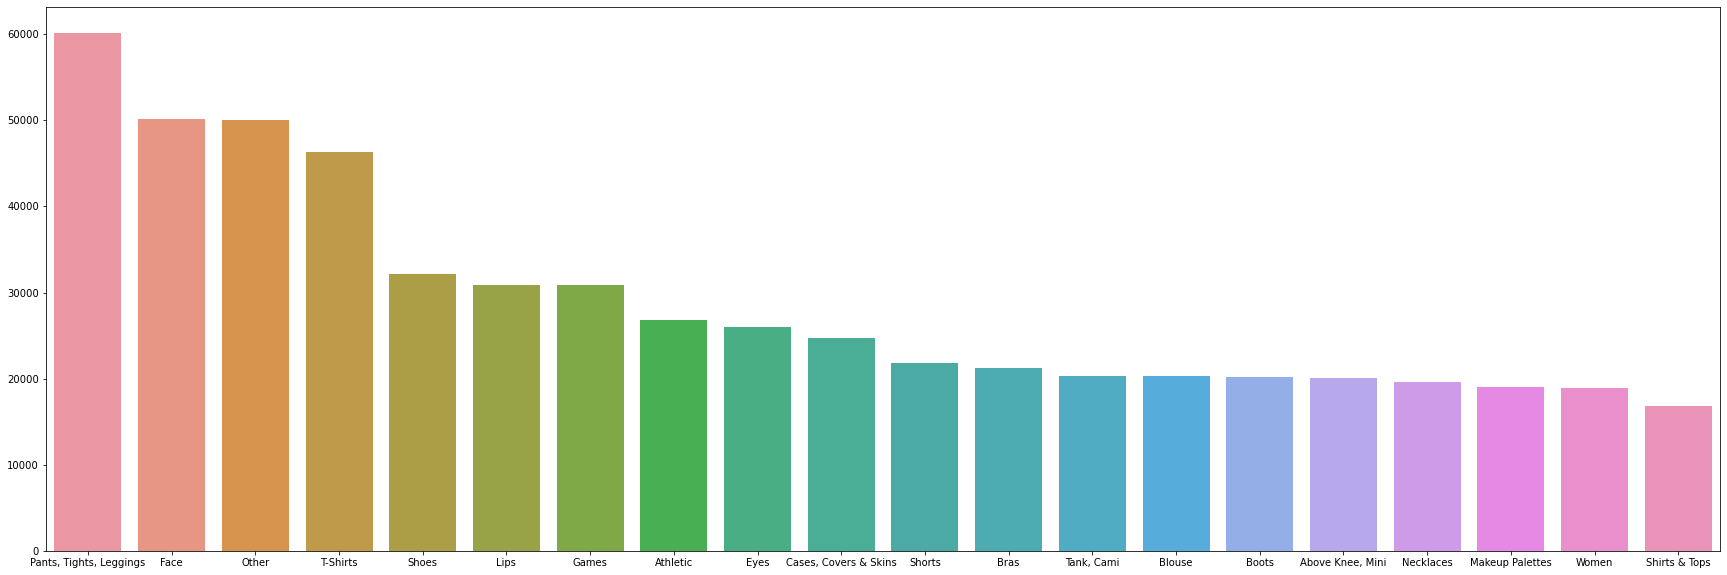

In [ ]:
#printing the the top 20 cat_3 with respect to their counts
# most of the cat_3 falls withi the 'Pants, Tights, Leggings','Face',others 
plt.figure(figsize = (30,10))
sns.barplot(list(train['cat_3'].value_counts()[:20].index),list(train['cat_3'].value_counts()[:20]))
plt.show()

**observations**
1.form the barplot on cat_3 feature it is clear that top product is  related to womens and second one is with category not given and the third product is related to womes cosmetics which tells us that in every sub category top products are related with womens and they are using the mercari website mainly.

In [ ]:
data=train[train['item_condition_id']==1]
data=data[data['price']>perce_90th]
data=data[data['brand_name']!='unknown']
print('top 5 brands with item_condition_id as 1 and price greater than 90th percetile value of prices are:',list(data['brand_name'].value_counts()[:5].index))

top 5 brands with item_condition_id as 1 and price greater than 90th percetile value of prices are: ['LuLaRoe', 'M', 'Nike', 'PINK', 'Michael Kors']


In [ ]:
data=train[train['item_condition_id']==2]
data=data[data['price']>perce_90th]
data=data[data['brand_name']!='unknown']
print('top 5 brands with item_condition_id as 2 and price greater than 90th percetile value of prices are:',list(data['brand_name'].value_counts()[:5].index))

top 5 brands with item_condition_id as 2 and price greater than 90th percetile value of prices are: ['Nike', 'Michael Kors', 'Lululemon', 'M', 'Apple']


In [ ]:
data=train[train['item_condition_id']==3]
data=data[data['price']>perce_90th]
data=data[data['brand_name']!='unknown']
print('top 5 brands with item_condition_id as 3 and price greater than 90th percetile value of prices are:',list(data['brand_name'].value_counts()[:5].index))

top 5 brands with item_condition_id as 3 and price greater than 90th percetile value of prices are: ['Nike', 'Apple', 'Michael Kors', 'Lululemon', 'M']


In [ ]:
data=train[train['item_condition_id']==4]
data=data[data['price']>perce_90th]
data=data[data['brand_name']!='unknown']
print('top 5 brands with item_condition_id as 4 and price greater than 90th percetile value of prices are:',list(data['brand_name'].value_counts()[:5].index))

top 5 brands with item_condition_id as 4 and price greater than 90th percetile value of prices are: ['Apple', 'Louis Vuitton', 'Air Jordan', 'Nike', 'Michael Kors']


In [ ]:
data=train[train['item_condition_id']==5]
data=data[data['price']>perce_90th]
data=data[data['brand_name']!='unknown']
print('top 5 brands with item_condition_id as 5 and price greater than 90th percetile value of prices are:',list(data['brand_name'].value_counts()[:5].index))

top 5 brands with item_condition_id as 5 and price greater than 90th percetile value of prices are: ['Apple', 'Samsung', 'Louis Vuitton', 'Sony', 'M']


**BIVARIATE ANALYSIS**

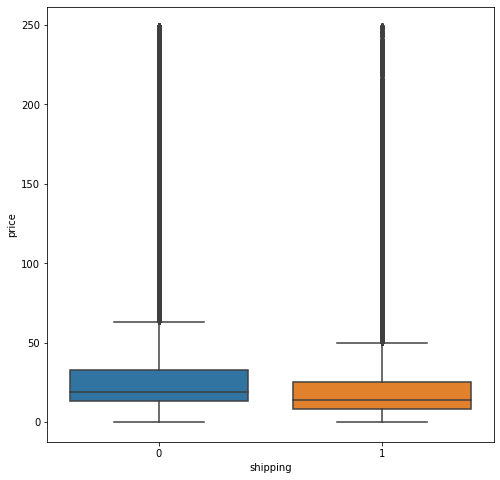

In [ ]:
# printing the boxplot between shipping and price
plt.figure(figsize=(8,8))
sns.boxplot(x=train.shipping,y=train.price)
plt.show()
# here 50th percentie of price with shipping 0 is grater than 50th percentile with shipping value 1,we can't predict price using just 3shipping itself

**observations**
1. from the box plot is is observed that when the shipping fee is paid by the buyer then price is somewhat higher when compared to price when shipping fee is paid by seller 

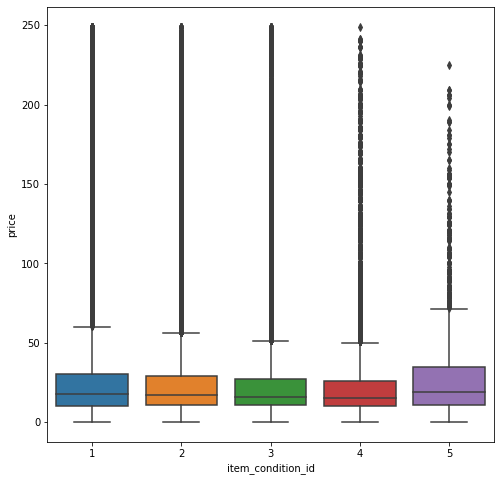

In [ ]:
# plotting the box plot between price and item_condition_id
plt.figure(figsize=(8,8))
sns.boxplot(x=train.item_condition_id,y=train.price)
plt.show()
# distribution of price over the different item condition seems to be same for all 1,2,3,4 except for the item_condition_id with value 5 where its price distribution is somewhat high. 

**observations**
1. from the box plot the price range with the item_conditons 1,2,3,4 are almost in same range.but the the 75th percentile of product with item-condition-id 5 is a bit higher when compared to others.

In [ ]:
print(list(train['cat_1'].value_counts()[:11].index))

['Women', 'Beauty', 'Kids', 'Electronics', 'Men', 'Home', 'Vintage & Collectibles', 'Other', 'Handmade', 'Sports & Outdoors', 'others']


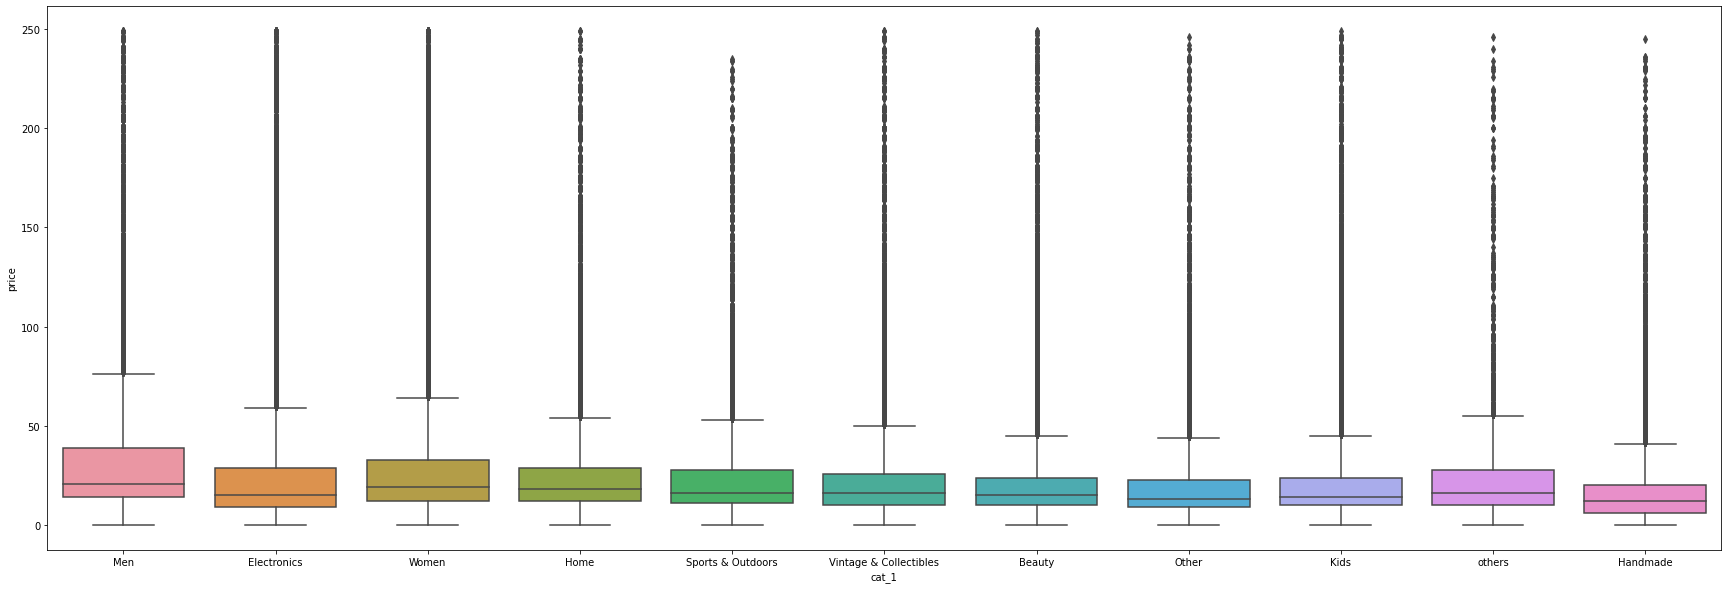

In [ ]:
# finding the data points where cat_1 feature is top 11 frequently occured words in cat_1
data1=train[train['cat_1'].isin(list(train['cat_1'].value_counts()[:11].index))]
# printing the box plot between top 11 cat_1 features and price 
plt.figure(figsize=(30,10))
sns.boxplot(x=data1.cat_1,y=data1.price)
plt.show()
# from the figure it is clear it is clear that price distribution for different category in cat_1 feature are almost overlapping 

**observations**
1. from the box plot of top 11 categories of cat_1 feature,it is difficult to predict the price of any of the product that belongs to those category.although the first category men has highest 75th percentile prize there is lot much overlap between men and other categories. 

In [ ]:
print(list(train['cat_2'].value_counts()[:10].index))

['Athletic Apparel', 'Makeup', 'Tops & Blouses', 'Shoes', 'Jewelry', 'Toys', 'Cell Phones & Accessories', 'Dresses', "Women's Handbags", "Women's Accessories"]


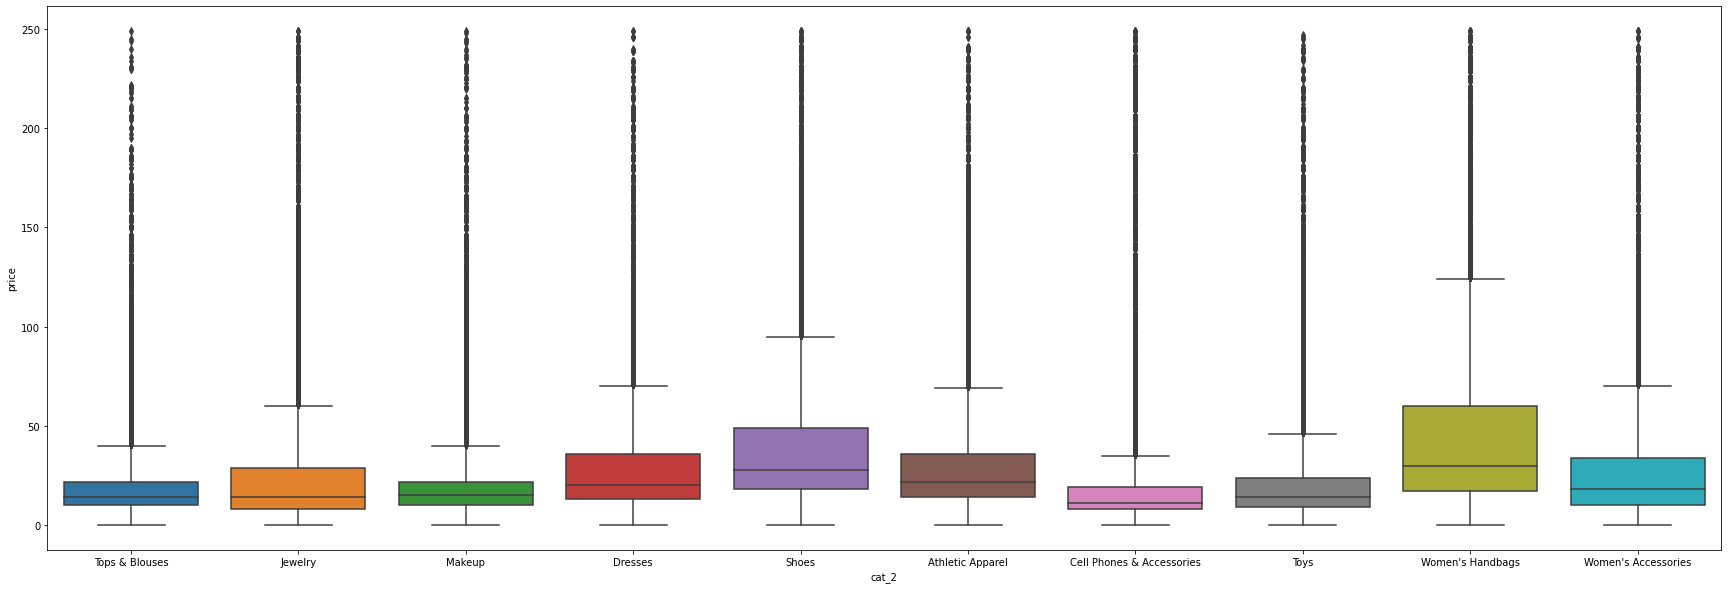

In [ ]:
# finding the data points where cat_2 feature is top 10 frequently occured words in cat_2
data1=train[train['cat_2'].isin(list(train['cat_2'].value_counts()[:10].index))]
# printing the box plot between top 10 cat_2 features and price 
plt.figure(figsize=(30,10))
sns.boxplot(x=data1.cat_2,y=data1.price)
plt.show()
# from the plot it is clear that price distribution for some cat_2 values are low and some values are high,but for the category women's handbags are pretty much higher when compared to others. 

**observations**
1. from the box plot of cat_2 feature, it is clear that price range of every of the category is same except with some categories like shoes and womens handbags,but predicting thr price range of those categories also somewwhat difficult because there is overlap region for them with lot many other categories.

In [ ]:
print(list(train['cat_3'].value_counts()[:10].index))

['Pants, Tights, Leggings', 'Face', 'Other', 'T-Shirts', 'Shoes', 'Lips', 'Games', 'Athletic', 'Eyes', 'Cases, Covers & Skins']


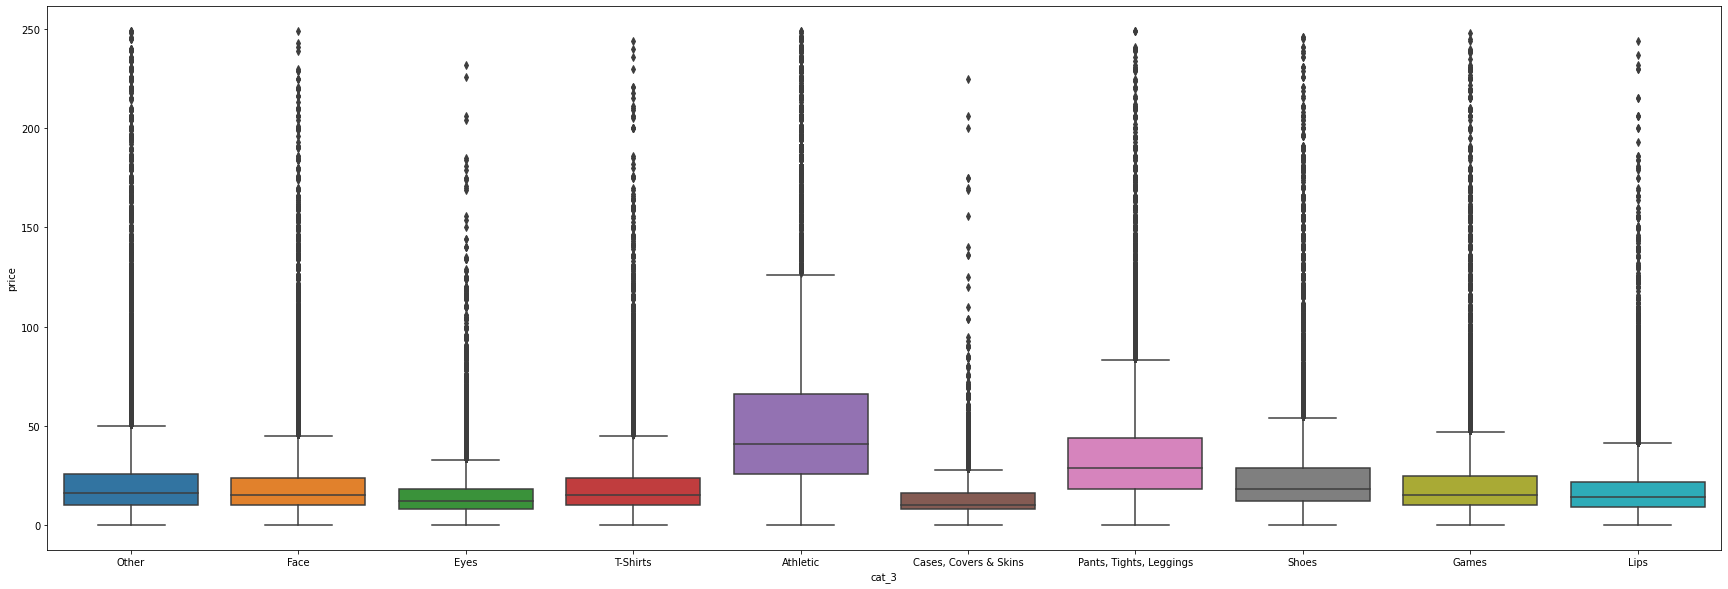

In [ ]:
# finding the data points where cat_3 feature is top 10 frequently occured words in cat_3
data1=train[train['cat_3'].isin(list(train['cat_3'].value_counts()[:10].index))]
# printing the box plot between top 10 cat_3 features and price 
plt.figure(figsize=(30,10))
sns.boxplot(x=data1.cat_3,y=data1.price)
plt.show()
# from the plot it is clear that price distribution of all the top categories are same except for two categories like athletic and pants,tights,leggins where their price disttribution is some what higher when compared to other categories 

**observations**
1. from the box plot of cat_3 feature, it is clear that price range of every of the category is same except with one category athletic.price range of athletic category is  higher compared to other category.we can predict the prie of these athletic category simply when compared to others.

In [ ]:
del data1

**multivariate analysis**

<Figure size 1080x1080 with 0 Axes>

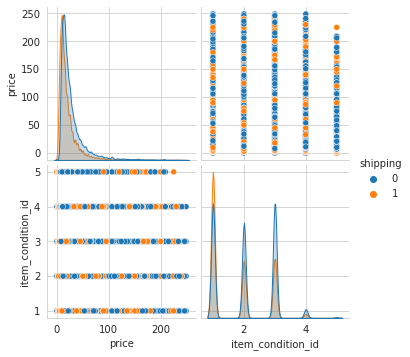

In [ ]:
plt.figure(figsize=(15,15))
sns.set_style("whitegrid");
sns.pairplot(train, hue="shipping",vars=['price','item_condition_id']);
plt.show()

**observations**
1. from the pair plot it is clear that in every small price range we have taken for every item condition there are datapoints with respect to shipping value both 0 and 1.so it is very difficult to predict the price by simply using these two features.

**adding no of words of item_description feature before preprocessing as a feature** 

In [ ]:
train['len']=[len(i.split()) for i in train.item_description.values]
test['len']=[len(i.split()) for i in test.item_description.values]

**PREPROCESSIG OF TEXT DATA**

In [ ]:
from nltk.corpus import stopwords
stopword=stopwords.words('english')

In [ ]:
import re

In [ ]:
def preprocess(td):
    td = re.sub(r"won't", "will not", td)
    td = re.sub(r"can\'t", "can not", td)
    td = re.sub(r"n\'t", " not", td)
    td = re.sub(r"\'re", " are", td)
    td = re.sub(r"\'s", " is", td)
    td = re.sub(r"\'d", " would", td)
    td = re.sub(r"\'ll", " will", td)
    td = re.sub(r"\'t", " not", td)
    td = re.sub(r"\'ve", " have", td)
    td = re.sub(r"\'m", " am", td)
    td = re.sub('\\n',' ',td)
    td = re.sub('\\"',' ',td)
    td = re.sub('\\n',' ',td)
    td = re.sub('[^A-Za-z0-9]+', ' ',td)
    td = ' '.join(i for i in td.split() if i.lower not in stopword)
    td.lower()
    return td

In [ ]:
train['item_description']=train['item_description'].apply(lambda i:preprocess(i))
test['item_description']=test['item_description'].apply(lambda i:preprocess(i))

**adding no of words of item_description feature after preprocessing as a feature** 

In [ ]:
train['len_af']=[len(i.split()) for i in train.item_description.values]
test['len_af']=[len(i.split()) for i in test.item_description.values]

**adding difference between length of item_description feature before and after preprocessing as a feature** 

In [ ]:
train['len_dif']=train['len']-train['len_af']
test['len_dif']=test['len']-test['len_af']

**doing setimental analysis on item_description feature**

In [ ]:
sen = SentimentIntensityAnalyzer()
neu=[]
pos=[]
neg=[]
com=[]
for i in train['item_description'].values:
    s=sen.polarity_scores(i)
    com.append(s['compound'])
    pos.append(s['pos'])
    neg.append(s['neg'])
    neu.append(s['neu'])
train['neg']=neg
train['pos']=pos
train['com']=com
train['neu']=neu
neu=[]
pos=[]
neg=[]
com=[]
for i in test['item_description'].values:
    s=sen.polarity_scores(i)
    com.append(s['compound'])
    pos.append(s['pos'])
    neg.append(s['neg'])
    neu.append(s['neu'])
test['neg']=neg
test['pos']=pos
test['com']=com
test['neu']=neu

In [ ]:
del neu
del pos
del neg
del com

In [ ]:
train.head(1)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,cat_1,cat_2,cat_3,log,len,len_af,len_dif,neg,pos,com,neu
849853,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,MLB,10.0,1,No description yet,Men,Tops,T-shirts,2.397895,3,3,0,0.524,0.0,-0.296,0.476


In [ ]:
test.head(1)

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description,cat_1,cat_2,cat_3,len,len_af,len_dif,neg,pos,com,neu
1984235,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,unknown,1,Size 7,Women,Jewelry,Rings,2,2,0,0.0,0.0,0.0,1.0


In [ ]:
train.to_csv('train_preprocessing.csv',index=False)
test.to_csv('test_preprocessing.csv',index=False)

In [3]:
train=pd.read_csv('train_preprocessing.csv')
test=pd.read_csv('test_preprocessing.csv')
print(train.shape)
print(test.shape)

(1476089, 19)
(3460725, 17)


In [4]:
train.item_description.fillna(value='desription not given',inplace=True)
test.item_description.fillna(value='desription not given',inplace=True)

In [5]:
test_id=test['test_id'].values

In [6]:
y=train['log'].values
X=train.drop(['price','category_name','log','train_id'],axis=1)

In [7]:
#train and test splitting of data
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=42)

**HANDLING CATEGORICAL FEATURES**

In [7]:
from sklearn.preprocessing import OneHotEncoder
vectorizer=OneHotEncoder(sparse=True, handle_unknown='ignore')
vectorizer.fit(X_train['brand_name'].values.reshape(-1,1))
X_train_brand=vectorizer.transform(X_train['brand_name'].values.reshape(-1,1))
X_test_brand=vectorizer.transform(X_test['brand_name'].values.reshape(-1,1))
test_brand=vectorizer.transform(test['brand_name'].values.reshape(-1,1))

vectorizer=OneHotEncoder(sparse=True, handle_unknown='ignore')
vectorizer.fit(X_train['cat_1'].values.reshape(-1,1))
X_train_cat_1=vectorizer.transform(X_train['cat_1'].values.reshape(-1,1))
X_test_cat_1=vectorizer.transform(X_test['cat_1'].values.reshape(-1,1))
test_cat_1=vectorizer.transform(test['cat_1'].values.reshape(-1,1))

vectorizer=OneHotEncoder(sparse=True, handle_unknown='ignore')
vectorizer.fit(X_train['cat_2'].values.reshape(-1,1))
X_train_cat_2=vectorizer.transform(X_train['cat_2'].values.reshape(-1,1))
X_test_cat_2=vectorizer.transform(X_test['cat_2'].values.reshape(-1,1))
test_cat_2=vectorizer.transform(test['cat_2'].values.reshape(-1,1))


vectorizer=OneHotEncoder(sparse=True, handle_unknown='ignore')
vectorizer.fit(X_train['cat_3'].values.reshape(-1,1))
X_train_cat_3=vectorizer.transform(X_train['cat_3'].values.reshape(-1,1))
X_test_cat_3=vectorizer.transform(X_test['cat_3'].values.reshape(-1,1))
test_cat_3=vectorizer.transform(test['cat_3'].values.reshape(-1,1))

from sklearn.feature_extraction.text import CountVectorizer
vectorizer=CountVectorizer(min_df=10)
vectorizer.fit(X_train['name'])
X_train_name=vectorizer.transform(X_train['name'])
X_test_name=vectorizer.transform(X_test['name'])
test_name=vectorizer.transform(test['name'])

print(X_train_name.shape)
print(X_test_name.shape)
print(test_name.shape)

(1254675, 16301)
(221414, 16301)
(3460725, 16301)


**HANDLING NUMERICAL FEATURES**

In [8]:
from sklearn.preprocessing import Normalizer
normalizer=Normalizer()
normalizer.fit(X_train['com'].values.reshape(-1,1))
X_train_compound=normalizer.transform(X_train['com'].values.reshape(-1,1))
X_test_compound=normalizer.transform(X_test['com'].values.reshape(-1,1))
test_compound=normalizer.transform(test['com'].values.reshape(-1,1))


normalizer=Normalizer()
normalizer.fit(X_train['neg'].values.reshape(-1,1))
X_train_neg=normalizer.transform(X_train['neg'].values.reshape(-1,1))
X_test_neg=normalizer.transform(X_test['neg'].values.reshape(-1,1))
test_neg=normalizer.transform(test['neg'].values.reshape(-1,1))


normalizer=Normalizer()
normalizer.fit(X_train['pos'].values.reshape(-1,1))
X_train_pos=normalizer.transform(X_train['pos'].values.reshape(-1,1))
X_test_pos=normalizer.transform(X_test['pos'].values.reshape(-1,1))
test_pos=normalizer.transform(test['pos'].values.reshape(-1,1))


normalizer=Normalizer()
normalizer.fit(X_train['neu'].values.reshape(-1,1))
X_train_neu=normalizer.transform(X_train['neu'].values.reshape(-1,1))
X_test_neu=normalizer.transform(X_test['neu'].values.reshape(-1,1))
test_neu=normalizer.transform(test['neu'].values.reshape(-1,1))


normalizer=Normalizer()
normalizer.fit(X_train['len'].values.reshape(-1,1))
X_train_len=normalizer.transform(X_train['len'].values.reshape(-1,1))
X_test_len=normalizer.transform(X_test['len'].values.reshape(-1,1))
test_len=normalizer.transform(test['len'].values.reshape(-1,1))


normalizer=Normalizer()
normalizer.fit(X_train['len_af'].values.reshape(-1,1))
X_train_len_af=normalizer.transform(X_train['len_af'].values.reshape(-1,1))
X_test_len_af=normalizer.transform(X_test['len_af'].values.reshape(-1,1))
test_len_af=normalizer.transform(test['len_af'].values.reshape(-1,1))


normalizer=Normalizer()
normalizer.fit(X_train['len_dif'].values.reshape(-1,1))
X_train_len_dif=normalizer.transform(X_train['len_dif'].values.reshape(-1,1))
X_test_len_dif=normalizer.transform(X_test['len_dif'].values.reshape(-1,1))
test_len_dif=normalizer.transform(test['len_dif'].values.reshape(-1,1))

**VECTORIZING ITEM_DESCRIPTION**

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=5,max_features=5000)
vectorizer.fit(X_train['item_description'].values)
X_train_des=vectorizer.transform(X_train['item_description'].values)
X_test_des=vectorizer.transform(X_test['item_description'].values)
test_des=vectorizer.transform(test['item_description'].values)

**VECTORIZING ORDINAL FEATURES**

In [9]:
X_train_ship=X_train['shipping'].values.reshape(-1,1)
X_test_ship=X_test['shipping'].values.reshape(-1,1)
test_ship=test['shipping'].values.reshape(-1,1)


X_train_cond=X_train['item_condition_id'].values.reshape(-1,1)
X_test_cond=X_test['item_condition_id'].values.reshape(-1,1)
test_cond=test['item_condition_id'].values.reshape(-1,1)


**COMBINING ALL FEATURES**

In [12]:
from scipy.sparse import hstack
X_train_features=hstack((X_train_brand,X_train_cat_1,X_train_cat_2,X_train_cat_3,X_train_ship,X_train_cond,X_train_des,X_train_name,X_train_compound,X_train_neg,X_train_pos,X_train_neu,X_train_len,X_train_len_af,X_train_len_dif)).tocsr()
X_test_features=hstack((X_test_brand,X_test_cat_1,X_test_cat_2,X_test_cat_3,X_test_ship,X_test_cond,X_test_des,X_test_name,X_test_compound,X_test_neg,X_test_pos,X_test_neu,X_test_len,X_test_len_af,X_test_len_dif)).tocsr()
test_features=hstack((test_brand,test_cat_1,test_cat_2,test_cat_3,test_ship,test_cond,test_des,test_name,test_compound,test_neg,test_pos,test_neu,test_len,test_len_af,test_len_dif)).tocsr()

**APPLYING LINEAR REGRESSIONS**

In [ ]:
%%time
from sklearn.linear_model import SGDRegressor
sgd=SGDRegressor(penalty='l2',loss='squared_loss',fit_intercept=True)
from sklearn.model_selection import RandomizedSearchCV
params={'alpha':[1e-15,1e-14,1e-13,1e-12,1e-11,1e-10,1e-09,0.00000001,0.00001,0.0001,0.001,0.01,0.1,0,1],'max_iter':[100,200,300,400,500]}
rs=RandomizedSearchCV(sgd,param_distributions=params,n_jobs=-1,verbose=10)
rs.fit(X_train_features,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 9.23 s, sys: 1.36 s, total: 10.6 s
Wall time: 1min 5s


RandomizedSearchCV(estimator=SGDRegressor(), n_jobs=-1,
                   param_distributions={'alpha': [1e-15, 1e-14, 1e-13, 1e-12,
                                                  1e-11, 1e-10, 1e-09, 1e-08,
                                                  1e-05, 0.0001, 0.001, 0.01,
                                                  0.1, 0, 1],
                                        'max_iter': [100, 200, 300, 400, 500]},
                   verbose=10)

In [ ]:
rs.best_params_

{'max_iter': 100, 'alpha': 1e-11}

In [14]:
%%time
from sklearn.linear_model import SGDRegressor
sgd=SGDRegressor(penalty='l2',loss='squared_loss',fit_intercept=True,max_iter=100,alpha=1e-11)
sgd.fit(X_train_features,y_train)

CPU times: user 7.88 s, sys: 456 ms, total: 8.34 s
Wall time: 7.52 s


SGDRegressor(alpha=1e-11, max_iter=100)

In [15]:
X_train_pred=sgd.predict(X_train_features)
X_test_pred=sgd.predict(X_test_features)
test_pred=sgd.predict(test_features)

In [16]:
rmsle_train=math.sqrt(mean_squared_error(y_train,X_train_pred))
rmsle_test=math.sqrt(mean_squared_error(y_test,X_test_pred))
print(rmsle_train)
print(rmsle_test)

0.4828123109134637
0.48574153713410284


In [17]:
test_pred=np.exp(test_pred)
submission=pd.DataFrame()
submission['test_id']=test_id
submission['price']=test_pred
submission.to_csv('submission_sgd.csv',index=False)

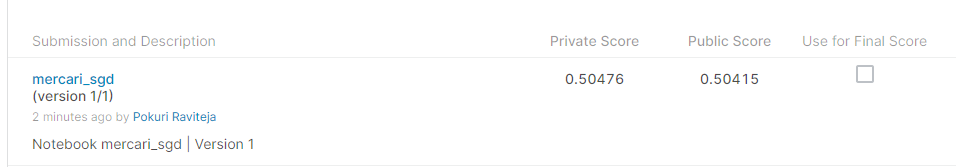

In [19]:
from IPython.display import Image
Image("Capture_sgd.PNG")

**APPLYING LGBM REGRESSOR**

In [ ]:
%%time
from lightgbm import LGBMRegressor
params = {
    'learning_rate': [ 0.1,0.2,0.3,0.4,0.5],
    'n_estimators': [100,150, 200,250,300,400,500],
    'num_leaves': [20,30,63,80,100,120],
    'boosting_type' : ['gbdt'],
    'max_depth' : [2,3,4,5,6,7,8]
}
lgb=LGBMRegressor()
rs=RandomizedSearchCV(lgb,param_distributions=params,n_jobs=-1,cv=3)
rs.fit(X_train_features,y_train)

CPU times: user 26min 57s, sys: 3.46 s, total: 27min
Wall time: 1h 26min 33s


RandomizedSearchCV(cv=3, estimator=LGBMRegressor(), n_jobs=-1,
                   param_distributions={'boosting_type': ['gbdt'],
                                        'learning_rate': [0.1, 0.2, 0.3, 0.4,
                                                          0.5],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8],
                                        'n_estimators': [100, 150, 200, 250,
                                                         300, 400, 500],
                                        'num_leaves': [20, 30, 63, 80, 100,
                                                       120]})

In [ ]:
rs.best_params_

{'num_leaves': 100,
 'n_estimators': 300,
 'max_depth': 5,
 'learning_rate': 0.5,
 'boosting_type': 'gbdt'}

In [30]:
%%time
from lightgbm import LGBMRegressor
lgb=LGBMRegressor(num_leaves=100,n_estimators=300,max_depth=9,learning_rate=0.5,boosting_type='gbdt')
lgb.fit(X_train_features,y_train)

CPU times: user 26min 22s, sys: 704 ms, total: 26min 23s
Wall time: 3min 24s


LGBMRegressor(learning_rate=0.5, max_depth=9, n_estimators=300, num_leaves=100)

In [31]:
X_train_pred=lgb.predict(X_train_features)
X_test_pred=lgb.predict(X_test_features)
test_pred=lgb.predict(test_features)
rmsle_train=math.sqrt(mean_squared_error(y_train,X_train_pred))
rmsle_test=math.sqrt(mean_squared_error(y_test,X_test_pred))
print(rmsle_train)
print(rmsle_test)

0.43781315057888137
0.46171564548071864


In [32]:
test_pred=np.exp(test_pred)
submission=pd.DataFrame()
submission['test_id']=test_id
submission['price']=test_pred
submission.to_csv('submission_lgb.csv',index=False)

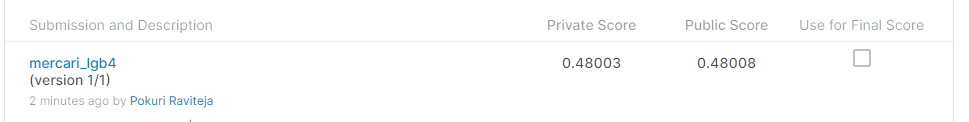

In [33]:
from IPython.display import Image
Image("Capture_lgb.PNG")

**APPLYING RANDOM FOREST REGRESSOR**

In [ ]:
%%time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
params = {
    'n_estimators': [100,200,300,400,500],
    'max_depth' : [2,3,4,5,6,7,8]
}
rfr=RandomForestRegressor()
rs=RandomizedSearchCV(rfr,param_distributions=params,n_jobs=-1,cv=3)
rs.fit(X_train_features,y_train)

CPU times: user 8h 14min, sys: 2.05 s, total: 8h 14min 2s
Wall time: 18h 40min 41s


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [2, 3, 4, 5, 6, 7, 8],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]})

In [ ]:
rs.best_params_

{'n_estimators': 300, 'max_depth': 7}

In [22]:
%%time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
rfr=RandomForestRegressor(min_samples_split=2,max_depth=7,n_estimators=300)
rfr.fit(X_train_features,y_train)


CPU times: user 4h 3min 51s, sys: 541 ms, total: 4h 3min 51s
Wall time: 4h 3min 54s


RandomForestRegressor(max_depth=7, n_estimators=300)

In [23]:
X_train_pred=rfr.predict(X_train_features)
X_test_pred=rfr.predict(X_test_features)
test_pred=rfr.predict(test_features)
rmsle_train=math.sqrt(mean_squared_error(y_train,X_train_pred))
rmsle_test=math.sqrt(mean_squared_error(y_test,X_test_pred))
print(rmsle_train)
print(rmsle_test)

0.6419817688677545
0.6441039797986526


In [24]:
test_pred=np.exp(test_pred)
submission=pd.DataFrame()
submission['test_id']=test_id
submission['price']=test_pred
submission.to_csv('submission_rfr.csv',index=False)

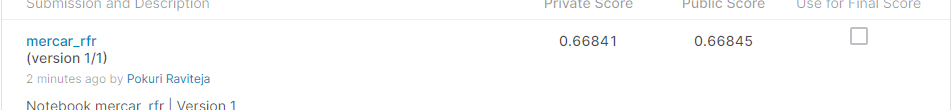

In [25]:
from IPython.display import Image
Image("Capture_rfr.PNG")

**APPLYING RIDGE REGRESSION**

In [13]:
%%time
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
params = {
    'alpha':[1e-15,1e-14,1e-13,1e-12,1e-11,1e-10,1e-09,0.00000001,0.00001,0.0001,0.001,0.01,0.1,0,1]
}
rcv=Ridge()
rs=RandomizedSearchCV(rcv,param_distributions=params,n_jobs=-1)
rs.fit(X_train_features,y_train)

CPU times: user 6min 55s, sys: 6min 30s, total: 13min 26s
Wall time: 12min 42s


RandomizedSearchCV(estimator=Ridge(), n_jobs=-1,
                   param_distributions={'alpha': [1e-15, 1e-14, 1e-13, 1e-12,
                                                  1e-11, 1e-10, 1e-09, 1e-08,
                                                  1e-05, 0.0001, 0.001, 0.01,
                                                  0.1, 0, 1]})

In [14]:
rs.best_params_

{'alpha': 0.1}

In [34]:
%%time
from sklearn.linear_model import Ridge
rcv=Ridge(alpha=0.1)
rcv.fit(X_train_features,y_train)

CPU times: user 6min 46s, sys: 6min 38s, total: 13min 25s
Wall time: 1min 54s


Ridge(alpha=0.1)

In [35]:
X_train_pred=rcv.predict(X_train_features)
X_test_pred=rcv.predict(X_test_features)
test_pred=rcv.predict(test_features)
rmsle_train=math.sqrt(mean_squared_error(y_train,X_train_pred))
rmsle_test=math.sqrt(mean_squared_error(y_test,X_test_pred))
print(rmsle_train)
print(rmsle_test)

0.45620080134056573
0.46797255631045837


In [36]:
test_pred=np.exp(test_pred)
submission=pd.DataFrame()
submission['test_id']=test_id
submission['price']=test_pred
submission.to_csv('submission_rcv.csv',index=False)

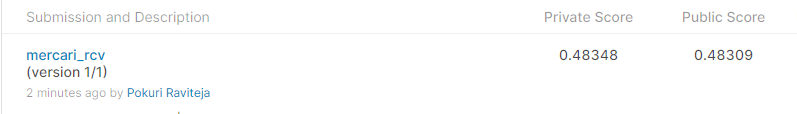

In [37]:
from IPython.display import Image
Image("Capture_rcv.PNG")

**DEEP LEARNING MODEL**

In [10]:
import keras
import tensorflow as tf
from keras.utils.vis_utils import plot_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dropout, Dense, concatenate, GRU, Embedding, Flatten, Activation,LSTM
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Conv1D

Using TensorFlow backend.


**handling categorical and text features**

In [11]:
tokenizer = Tokenizer(oov_token="oov" )
tokenizer.fit_on_texts(X_train["item_description"])
X_train_desc  = tokenizer.texts_to_sequences(X_train['item_description'].values)
X_test_desc   = tokenizer.texts_to_sequences(X_test['item_description'].values)
test_desc     = tokenizer.texts_to_sequences(test['item_description'].values)
X_train_desc = pad_sequences(X_train_desc, maxlen=50 , padding='post' )
X_test_desc  = pad_sequences(X_test_desc, maxlen=50 , padding='post')
test_desc      = pad_sequences(test_desc, maxlen=50 , padding='post')
unique_desc = len(tokenizer.word_index)+1
print(X_train_desc.shape)
print(X_test_desc.shape)
print(test_desc.shape)

tokenizer = Tokenizer(oov_token="oov" )
tokenizer.fit_on_texts(X_train["name"])
X_train_name  = tokenizer.texts_to_sequences(X_train['name'].values)
X_test_name   = tokenizer.texts_to_sequences(X_test['name'].values)
test_name     = tokenizer.texts_to_sequences(test['name'].values)
X_train_name = pad_sequences(X_train_name, maxlen=15 , padding='post' )
X_test_name  = pad_sequences(X_test_name, maxlen=15 , padding='post')
test_name    = pad_sequences(test_name, maxlen=15 , padding='post')
unique_name = len(tokenizer.word_index)+1
print(X_train_name.shape)
print(X_test_name.shape)
print(test_name.shape)


tokenizer = Tokenizer(oov_token="oov" )
tokenizer.fit_on_texts(X_train["brand_name"])
X_train_brand  = tokenizer.texts_to_sequences(X_train['brand_name'].values)
X_test_brand   = tokenizer.texts_to_sequences(X_test['brand_name'].values)
test_brand     = tokenizer.texts_to_sequences(test['brand_name'].values)
r=max([len(x) for x in X_train_brand])
print(r)
X_train_brand = pad_sequences(X_train_brand, maxlen=r , padding='post' )
X_test_brand  = pad_sequences(X_test_brand, maxlen=r , padding='post')
test_brand    = pad_sequences(test_brand, maxlen=r , padding='post')
unique_brand = len(tokenizer.word_index)+1
print(X_train_brand.shape)
print(X_test_brand.shape)
print(test_brand.shape)


tokenizer = Tokenizer(oov_token="oov" )
tokenizer.fit_on_texts(X_train["cat_1"])
X_train_cat_1  = tokenizer.texts_to_sequences(X_train['cat_1'].values)
X_test_cat_1   = tokenizer.texts_to_sequences(X_test['cat_1'].values)
test_cat_1     = tokenizer.texts_to_sequences(test['cat_1'].values)
r=max([len(x) for x in X_train_cat_1])
print(r)
X_train_cat_1 = pad_sequences(X_train_cat_1, maxlen=r , padding='post' )
X_test_cat_1  = pad_sequences(X_test_cat_1, maxlen=r , padding='post')
test_cat_1    = pad_sequences(test_cat_1, maxlen=r , padding='post')
unique_cat_1 = len(tokenizer.word_index)+1
print(X_train_cat_1.shape)
print(X_test_cat_1.shape)
print(test_cat_1.shape)


tokenizer = Tokenizer(oov_token="oov" )
tokenizer.fit_on_texts(X_train["cat_2"])
X_train_cat_2  = tokenizer.texts_to_sequences(X_train['cat_2'].values)
X_test_cat_2   = tokenizer.texts_to_sequences(X_test['cat_2'].values)
test_cat_2     = tokenizer.texts_to_sequences(test['cat_2'].values)
r=max([len(x) for x in X_train_cat_2])
print(r)
X_train_cat_2 = pad_sequences(X_train_cat_2, maxlen=r , padding='post' )
X_test_cat_2  = pad_sequences(X_test_cat_2, maxlen=r , padding='post')
test_cat_2    = pad_sequences(test_cat_2, maxlen=r , padding='post')
unique_cat_2 = len(tokenizer.word_index)+1
print(X_train_cat_2.shape)
print(X_test_cat_2.shape)
print(test_cat_2.shape)


tokenizer = Tokenizer(oov_token="oov" )
tokenizer.fit_on_texts(X_train["cat_3"])
X_train_cat_3  = tokenizer.texts_to_sequences(X_train['cat_3'].values)
X_test_cat_3   = tokenizer.texts_to_sequences(X_test['cat_3'].values)
test_cat_3     = tokenizer.texts_to_sequences(test['cat_3'].values)
r=max([len(x) for x in X_train_cat_3])
print(r)
X_train_cat_3 = pad_sequences(X_train_cat_3, maxlen=r , padding='post' )
X_test_cat_3  = pad_sequences(X_test_cat_3, maxlen=r , padding='post')
test_cat_3    = pad_sequences(test_cat_3, maxlen=r , padding='post')
unique_cat_3 = len(tokenizer.word_index)+1
print(X_train_cat_3.shape)
print(X_test_cat_3.shape)
print(test_cat_3.shape)

(1254675, 50)
(221414, 50)
(3460725, 50)
(1254675, 15)
(221414, 15)
(3460725, 15)
8
(1254675, 8)
(221414, 8)
(3460725, 8)
2
(1254675, 2)
(221414, 2)
(3460725, 2)
4
(1254675, 4)
(221414, 4)
(3460725, 4)
6
(1254675, 6)
(221414, 6)
(3460725, 6)


**combining all numerical features**

In [12]:
X_train_numeric_features=np.concatenate((X_train_compound, X_train_pos,X_train_neu,X_train_neg,X_train_len,X_train_len_af,X_train_len_dif,X_train_ship,X_train_cond) , axis = 1)
X_test_numeric_features=np.concatenate((X_test_compound, X_test_pos,X_test_neu,X_test_neg,X_test_len,X_test_len_af,X_test_len_dif,X_test_ship,X_test_cond) , axis = 1)
test_numeric_features=np.concatenate((test_compound, test_pos,test_neu,test_neg,test_len,test_len_af,test_len_dif,test_ship,test_cond) , axis = 1)
print(X_train_numeric_features.shape)
print(X_test_numeric_features.shape)
print(test_numeric_features.shape)

(1254675, 9)
(221414, 9)
(3460725, 9)


**model architecture**

In [13]:
desc=Input(shape=(50,),name='description')
e1=Embedding(output_dim=60,input_dim=unique_desc)(desc)
l1=Conv1D(filters=32,kernel_size=3,strides=2,padding='same')(e1)
l2=Conv1D(filters=32,kernel_size=3,strides=2,padding='same')(l1)
l3=LSTM(32,return_sequences=True)(l2)
l4=LSTM(16,return_sequences=True)(l3)
f1=Flatten()(l4)
name=Input(shape=(15,),name='name')
e2=Embedding(output_dim=30,input_dim=unique_name)(name)
l5=Conv1D(filters=32,kernel_size=3,strides=2,padding='same')(e2)
l6=Conv1D(filters=32,kernel_size=3,strides=2,padding='same')(l5)
l7=LSTM(16,return_sequences=True)(l6)
l8=LSTM(8,return_sequences=True)(l7)
f2=Flatten()(l8)
brand=Input(shape=(8,),name='brand')
e3=Embedding(output_dim=20,input_dim=unique_brand)(brand)
f3=Flatten()(e3)
cat_1=Input(shape=(2,),name='cat_1')
e4=Embedding(output_dim=10,input_dim=unique_cat_1)(cat_1)
f4=Flatten()(e4)
cat_2=Input(shape=(4,),name='cat_2')
e5=Embedding(output_dim=15,input_dim=unique_cat_2)(cat_2)
f5=Flatten()(e5)
cat_3=Input(shape=(6,),name='cat_3')
e6=Embedding(output_dim=20,input_dim=unique_cat_3)(cat_3)
f6=Flatten()(e6)
nume=Input(shape=(9,),name='numeric_features')
concat = concatenate([f1 , f2 , f3 ,f4 , f5 , f6 , nume],axis=1)
d1=Dense(512,kernel_initializer='normal',activation='relu')(concat)
dr1=Dropout(0.05)(d1)
d2=Dense(128,kernel_initializer='normal',activation='relu')(dr1)
dr2=Dropout(0.05)(d2)
output = Dense(1, activation="linear")(dr2)
model=Model(inputs=[desc,name,brand,cat_1,cat_2,cat_3,nume],outputs=[output])
print(model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
description (InputLayer)        [(None, 50)]         0                                            
__________________________________________________________________________________________________
name (InputLayer)               [(None, 15)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 60)       8757060     description[0][0]                
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 15, 30)       3230040     name[0][0]                       
_______________________________________________________________________________________

In [14]:
model.compile(optimizer='adam', loss='mse')
model.fit([X_train_desc,X_train_name,X_train_brand,X_train_cat_1,X_train_cat_2,X_train_cat_3,X_train_numeric_features],y_train,verbose=1,epochs=10,batch_size=1024,callbacks=tf.keras.callbacks.EarlyStopping(min_delta=0.01,monitor='val_loss',restore_best_weights=True,patience=4),validation_data=([X_test_desc,X_test_name,X_test_brand,X_test_cat_1,X_test_cat_2,X_test_cat_3,X_test_numeric_features],y_test))

Epoch 1/10
1226/1226 [==============================] - 362s 296ms/step - loss: 0.2804 - val_loss: 0.2034
Epoch 2/10
1226/1226 [==============================] - 356s 291ms/step - loss: 0.1923 - val_loss: 0.1974
Epoch 3/10
1226/1226 [==============================] - 358s 292ms/step - loss: 0.1656 - val_loss: 0.1985
Epoch 4/10
1226/1226 [==============================] - 358s 292ms/step - loss: 0.1468 - val_loss: 0.2035
Epoch 5/10
1226/1226 [==============================] - 360s 293ms/step - loss: 0.1325 - val_loss: 0.1983


In [15]:
X_train_pred=model.predict([X_train_desc,X_train_name,X_train_brand,X_train_cat_1,X_train_cat_2,X_train_cat_3,X_train_numeric_features])
X_test_pred=model.predict([X_test_desc,X_test_name,X_test_brand,X_test_cat_1,X_test_cat_2,X_test_cat_3,X_test_numeric_features])
test_pred=model.predict([test_desc,test_name,test_brand,test_cat_1,test_cat_2,test_cat_3,test_numeric_features])
rmsle_train=math.sqrt(mean_squared_error(y_train,X_train_pred))
rmsle_test=math.sqrt(mean_squared_error(y_test,X_test_pred))
print(rmsle_train)
print(rmsle_test)

0.4260290313851057
0.45096916384213576


In [16]:
test_pred=np.exp(test_pred)
submission=pd.DataFrame()
submission['test_id']=test_id
submission['price']=test_pred
submission.to_csv('submission_dep3.csv',index=False)

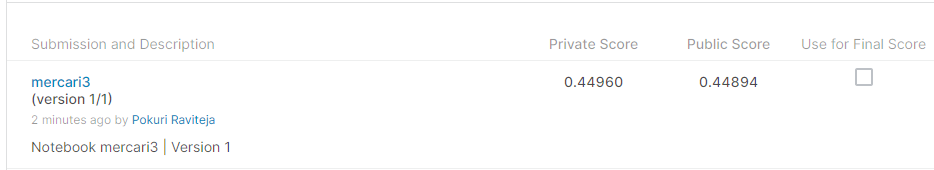

In [3]:
from IPython.display import Image
Image("Capture.PNG")